# Import Libray, Load Dataset, Print shape for data, Visualize images in dataset

In [191]:
from google.colab import drive

In [192]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [193]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [194]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [195]:
# Import necessary modules.
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow

In [196]:
# Load Data
data = np.load('/content/drive/My Drive/Project_Plant_Seeds/images.npy')
labels = pd.read_csv('/content/drive/My Drive/Project_Plant_Seeds/Labels.csv')

In [197]:
#print the shape of the dataset
data.shape

(4750, 128, 128, 3)

There are 4750 records with 32x32 pixels image and each image has 3 color channels (RBG)

In [198]:
# for labels:
labels.shape

(4750, 1)

In [199]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

In [200]:
# Visualizing a few pictures 

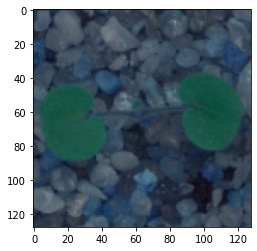

In [201]:
plt.imshow(data[0])

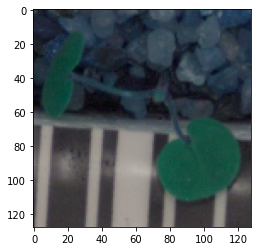

In [202]:
plt.imshow(data[10])

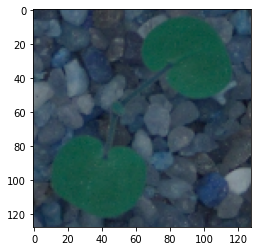

In [203]:
plt.imshow(data[100])

# 2. Data Processing

## a. Normalization 

In [208]:
# normalize our data by dividing the RGB code with 255 + use floating value to make sure we can get decimal points after division 
data_norm=  data.astype('float32')
data_norm/= 255

## b. Gaussian Blurring

In [209]:
data_norm.mean()

0.2746806


 Output after first gaussian blurring: 



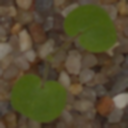

In [212]:
image=data[100]
Gaussian1 = cv2.GaussianBlur(image, (5, 5), 0)
print('\n Output after first gaussian blurring: \n')
cv2_imshow(Gaussian1)

In [213]:
for i in range(4750):
  Gaussian2 = cv2.GaussianBlur(data[i], (5, 5), 0)

# 3- Make data compatible

## a.Convert labels to one-hot-vectors.

In [138]:
# Convert labels to one hot vectors.

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
labels = enc.fit_transform(labels)

In [139]:
print(labels.shape)

(4750, 12)


## b. Print the label for y_train[0].

In [140]:
print(labels[0])

[0 0 0 0 0 0 0 0 0 0 1 0]


## c. Split the dataset into training, testing, and validation set.

In [141]:
#Divide the data set into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_norm, labels, test_size=0.30, random_state=77)

In [142]:
#Divide the test set into training and validation sets
X_test2, X_valid, Y_test2, Y_valid = train_test_split(X_test, Y_test, test_size=0.50, random_state=77)

## d. Check the shape of data, Reshape data into shapes compatible with Keras models

In [143]:
# check the shape of data
print(X_train.shape)
print(X_test2.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_test2.shape)
print(Y_valid.shape)

(3325, 128, 128, 3)
(712, 128, 128, 3)
(713, 128, 128, 3)
(3325, 12)
(712, 12)
(713, 12)


In [144]:
#Reshape data 
X_train = X_train.reshape(3325, 128, 128, 3)
X_test2 = X_test2.reshape(712, 128, 128, 3)
X_valid = X_valid.reshape(713, 128, 128, 3)

In [145]:
print("X_train shape:", X_train.shape)
print("Images in X_train:", X_train.shape[0])
print("Images in X_test2:", X_test2.shape[0])
print("Images in X_valid:", X_valid.shape[0])

X_train shape: (3325, 128, 128, 3)
Images in X_train: 3325
Images in X_test2: 712
Images in X_valid: 713


# 4. Building CNN 

## a. Define layers 

In [146]:
from tensorflow.keras.layers import Conv2D

model = models.Sequential()

model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 64)       

## b.Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)


In [150]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [151]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# 5. Fit and evaluate model and print confusion matrix. 

In [156]:
# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Use earlystopping
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, min_delta=0.01)

# Fit the model
model.fit(x=X_train, y=Y_train, batch_size=32, epochs=10, validation_data=(X_valid, Y_valid), callbacks=[callback])

52/52 [==============================] - 204s 4s/step - loss: 1.4271 - accuracy: 0.5134 - val_loss: 2.4794 - val_accuracy: 0.1627


In [215]:
# Evaluate the model
results = model.evaluate(X_test2, Y_test2,verbose=0)
Y_pred=model.predict_classes(X_test2)

In [217]:
confusion_matrix(Y_test2.values, Y_pred)

AttributeError: ignored

# 6.Visualize predictions

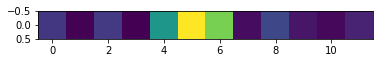

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline

# for x_test[2]
y_pred_2 = model.predict(X_test2[2].reshape(1, 128, 128, 3))
plt.imshow(y_pred_2)




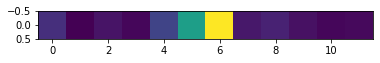

In [181]:

# for x_test[3]
y_pred_3 = model.predict(X_test2[3].reshape(1, 128, 128, 3))
plt.imshow(y_pred_3)

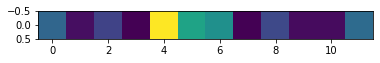

In [182]:
#x_test[33]
y_pred_33 = model.predict(X_test2[33].reshape(1, 128, 128, 3))
plt.imshow(y_pred_33)

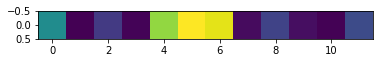

In [183]:
#x_test[36]
y_pred_36 = model.predict(X_test2[36].reshape(1, 128, 128, 3))
plt.imshow(y_pred_36)

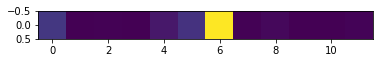

In [184]:
 #x_test[59]
 y_pred_59 = model.predict(X_test2[59].reshape(1, 128, 128, 3))
plt.imshow(y_pred_59)

The model is not providing good prediction. 